In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.7/793.7 kB 5.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

Ultralytics YOLOv8.2.48 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.2/107.7 GB disk)

Found https://i.pinimg.com/564x/87/76/29/8776299d66f8dd8e71595ead017966ba.jpg locally at 8776299d66f8dd8e71595ead017966ba.jpg
image 1/1 /content/drive/MyDrive/ikea-master/8776299d66f8dd8e71595ead017966ba.jpg: 640x640 (no detections), 488.3ms
Speed: 28.0ms preprocess, 488.3ms inference, 17.3ms postprocess per image at shape (1, 3, 640, 640)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 125MB/s]


Features extracted for all cropped images.
Features extracted for all catalog images.
Recommendations generated.


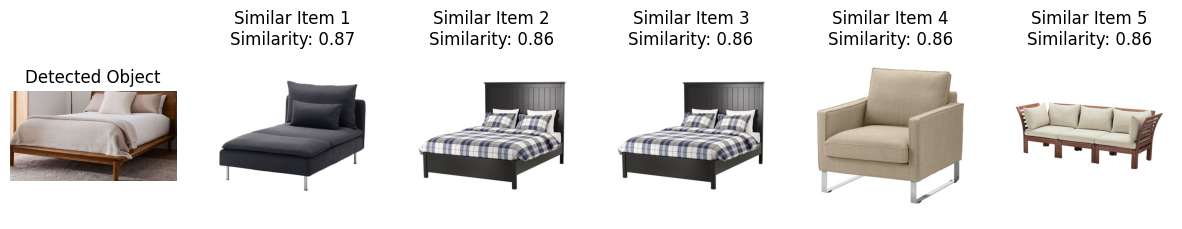

In [ ]:
import os
import cv2
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/ikea-master')



from IPython.display import display, Image as IPImage
import ultralytics
ultralytics.checks()

model = YOLO('yolov8n.pt')

# Function to extract features using a pre-trained ResNet model
def extract_features(image_path):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    model = models.resnet50(pretrained=True)
    model.eval()

    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    image = image.unsqueeze(0)

    with torch.no_grad():
        features = model(image)

    return features.squeeze().numpy()

# Load an example image and perform object detection
results = model(source="https://i.pinimg.com/564x/87/76/29/8776299d66f8dd8e71595ead017966ba.jpg", conf=0.8)

# Directory to save cropped images
cropped_images_dir = "cropped_images"
os.makedirs(cropped_images_dir, exist_ok=True)

# Crop detected objects from the image
for i, result in enumerate(results):
    img = result.orig_img
    for j, box in enumerate(result.boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cropped_img = img[y1:y2, x1:x2]
        cropped_img_path = os.path.join(cropped_images_dir, f"cropped_{i}_{j}.jpg")
        cv2.imwrite(cropped_img_path, cropped_img)
        print(f"Cropped image saved to {cropped_img_path}")

# Extract features for all cropped images
feature_dict = {}
for img_path in os.listdir(cropped_images_dir):
    full_img_path = os.path.join(cropped_images_dir, img_path)
    if os.path.isfile(full_img_path):  # Ensure it's a file
        features = extract_features(full_img_path)
        feature_dict[img_path] = features

print("Features extracted for all cropped images.")

# Load catalog images and extract features
catalog_dir = "/content/drive/MyDrive/ikea-master/images"
catalog_features = {}

# List of allowed image extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

for category in os.listdir(catalog_dir):
    category_path = os.path.join(catalog_dir, category)
    if os.path.isdir(category_path):  # Ensure it's a directory
        for img_path in os.listdir(category_path):
            full_img_path = os.path.join(category_path, img_path)
            if os.path.isfile(full_img_path) and os.path.splitext(full_img_path)[1].lower() in image_extensions:  # Ensure it's an image file
                features = extract_features(full_img_path)
                catalog_features[f"{category}/{img_path}"] = features

print("Features extracted for all catalog images.")

# Function to find similar items
def find_similar_items(features, catalog_features, top_k=5):
    similarities = []
    for img_path, catalog_feature in catalog_features.items():
        similarity = cosine_similarity(features.reshape(1, -1), catalog_feature.reshape(1, -1))[0][0]
        similarities.append((img_path, similarity))
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]

# Find similar items for each detected object
recommendations = {}
for img_name, features in feature_dict.items():
    similar_items = find_similar_items(features, catalog_features)
    recommendations[img_name] = similar_items

print("Recommendations generated.")

# Display the original image with detected objects and recommendations
for img_name, similar_items in recommendations.items():
    cropped_img_path = os.path.join(cropped_images_dir, img_name)
    cropped_img = Image.open(cropped_img_path)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, len(similar_items) + 1, 1)
    plt.imshow(cropped_img)
    plt.title("Detected Object")
    plt.axis('off')

    for i, (item_img, similarity) in enumerate(similar_items, start=2):
        item_img_path = os.path.join(catalog_dir, item_img)
        item_img = Image.open(item_img_path)
        plt.subplot(1, len(similar_items) + 1, i)
        plt.imshow(item_img)
        plt.title(f"Similar Item {i-1}\nSimilarity: {similarity:.2f}")
        plt.axis('off')

    plt.show()




